In [4]:
import torch
from torch import nn

### Plan of action
- develop basic unet
- try extending basic unet to diffusion or what I understand by diffusion 

Basic blocks of UNet
image input -> 128*128
for (1,n)
    downscale(image) 
    

In [3]:
random_image = torch.rand(4,3,128,128)
random_image.shape

torch.Size([4, 3, 128, 128])

In [18]:
m = nn.Conv2d(3,64,3,1)

In [34]:
pool = nn.AvgPool2d(2,2)

In [35]:
pool(m(random_image))

torch.Size([4, 64, 63, 63])

## Building blocks

In [33]:
# Double conv 

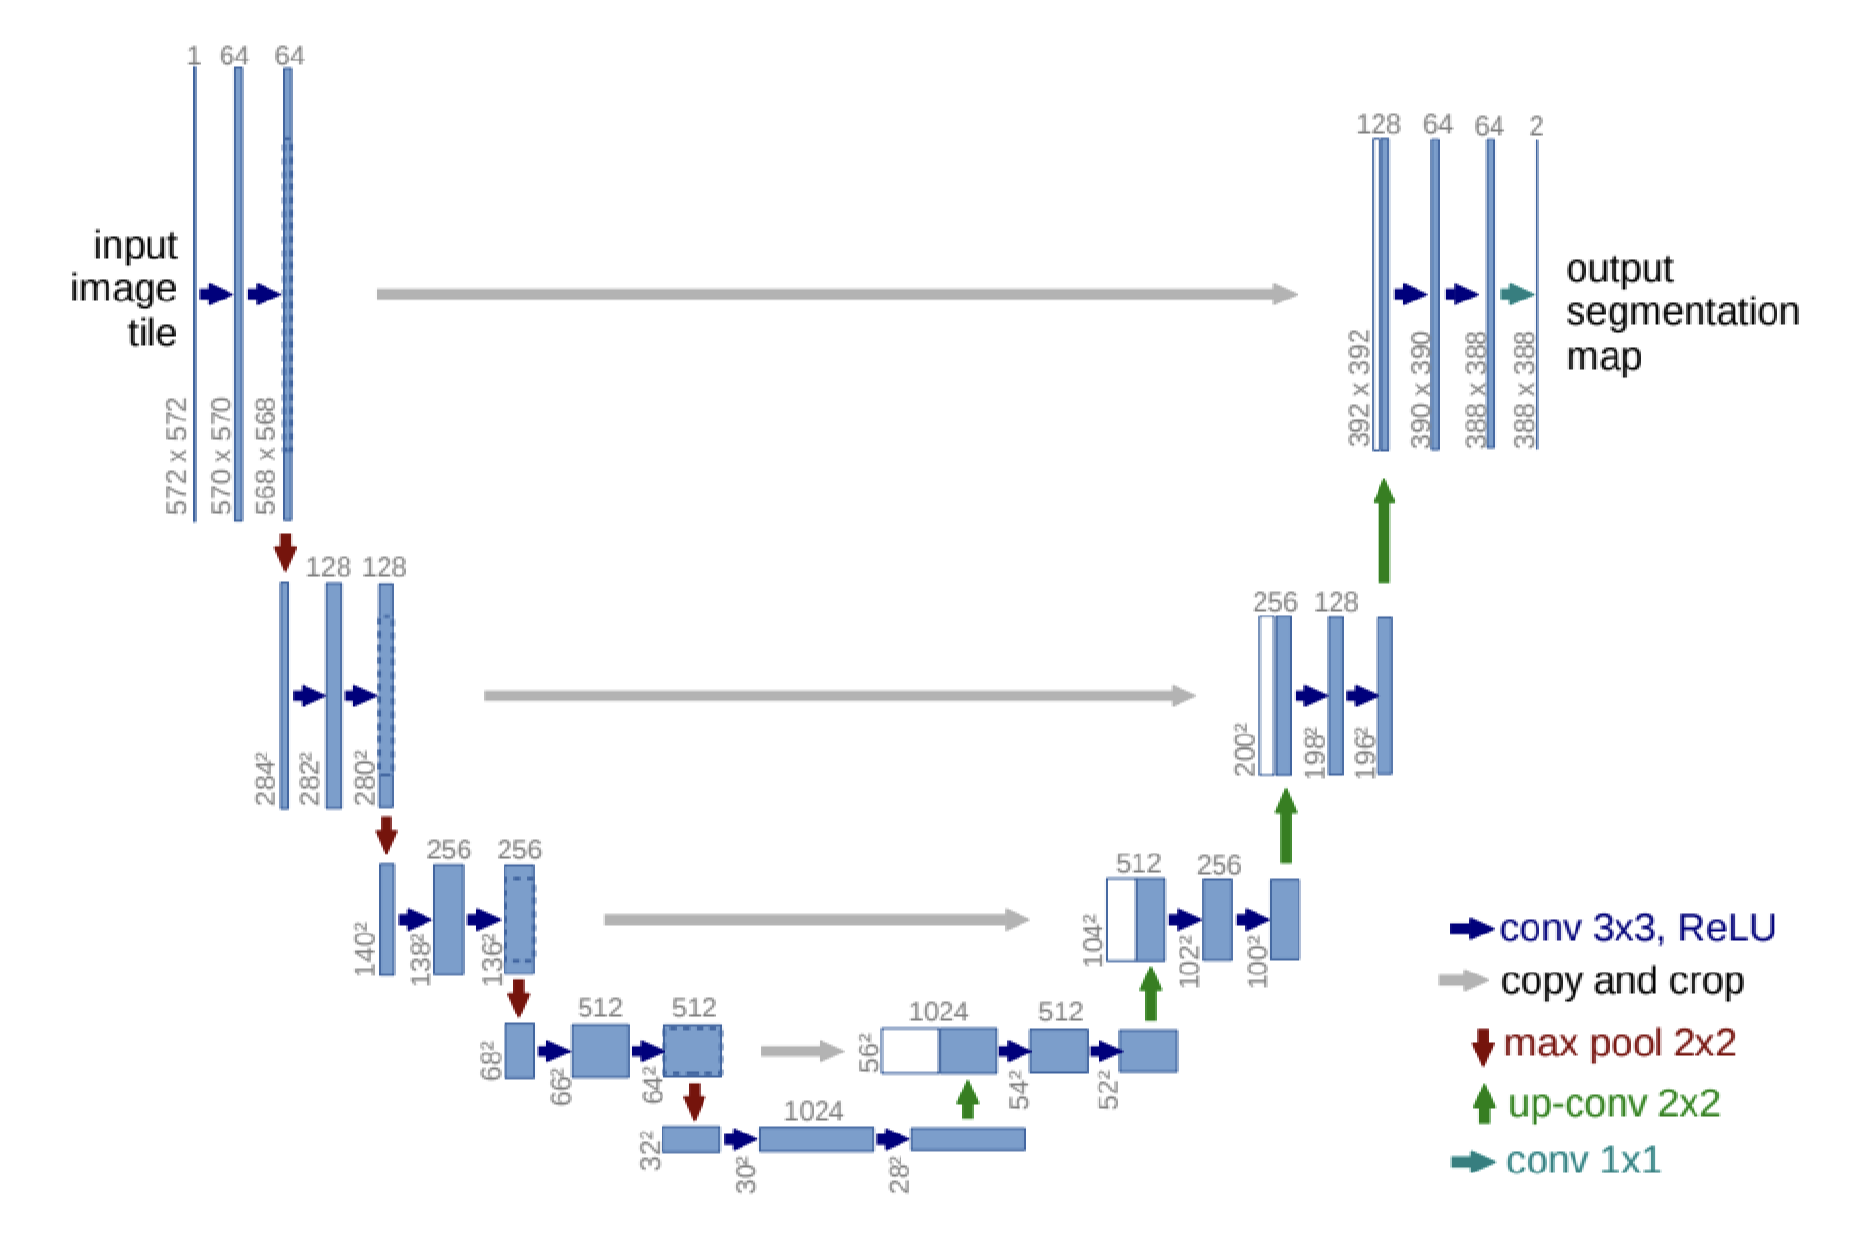

In [30]:
class DoubleConv(nn.Module):
    """
    2  convlayers
    """
    def __init__(self, channels, feature_map_size, kernel_size, stride):
        super().__init__()
        self.conv_seq = nn.Sequential(
            nn.Conv2d(channels,feature_map_size[0],kernel_size,stride),
            nn.BatchNorm2d(feature_map_size[0]),
            nn.ReLU(),
            nn.Conv2d(feature_map_size[0],feature_map_size[1],kernel_size,stride),
            nn.BatchNorm2d(feature_map_size[1]),
            nn.ReLU()
        )
        
    def forward(self,inp):
        return self.conv_seq(inp)

In [36]:
dc = DoubleConv(channels=3, feature_map_size=[64,64],kernel_size=3,stride=1)
apool = nn.AdaptiveAvgPool2d
dc(random_image)

torch.Size([4, 64, 124, 124])

In [ ]:
class Upscale(nn.Module):
    """
    2  convlayers
    """
    def __init__(self, channels, feature_map_size, kernel_size, stride):
        super().__init__()
        self.conv = DoubleConv()
        self.apool = nn.AdaptiveAvgPool2d()
        
    def forward(self,inp):
        return self.conv_seq(inp)

In [ ]:
# DoubleConv -> DoubleConv -> out, avgpool(out)
